<a href="https://colab.research.google.com/github/himalayahall/LargeLanguageModels/blob/main/Building_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

## Load data

Load text file containing (USA) the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames) for the year 2018.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/karpathy/makemore/master/names.txt', header=None, names=['name'])

In [ ]:
df.shape

(32033, 1)

In [ ]:
df.head()

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia


Find out min/max length of names in the dataset.

In [ ]:
min(ln for ln in df['name'].str.len())

2

In [ ]:
max(ln for ln in df['name'].str.len())

15

## Character level language model

A character level language model is predicting the next character given some concrete sequence of characters before it.

For example, the name *olivia* tells us the following:

- **letter *o* is a likely character to come at the start of a name**
- letter *l* is likely to come after letter *o*
- letter *i* is likely to come after letters *ol*
- letter *v* is likely to come after letters *oli*
- letter *i* is likely to come after letters *oliv*
- letter *a* is likely to come after letters *olivi*
- **letter *a* is likely to be the final letter in a name**

## Bigram

In a **Bigram** language model we are working with 2-character sequences. In other words, we are predicting the next character based on just 1 previous character. Although very rudimentary, this is the simplest possible language model and therefore a good starting point.

In [ ]:
# extract names into a list for ease of use
words = list(df['name'])

In [ ]:
# print bigrams for first name
# Fun fact: works because zip() does element wise pairing of elements from 2 iterators, but if one iterator runs out of elements, then zip terminates
# the sequence. As an example, for the name 'emma', the first iterator contains 'emma' and the second iterator contains 'mma'. As a result, the sequence
# produced by zip is: (e,m), (m, m), (m, a)

for w in words[:1]:
  for c1, c2 in zip(w, w[1:]):
    print(c1, c2)

e m
m m
m a


But we have more information at hand: we know that the letter *e* is likely to come first and letter *a* is likely to come last. 

To keep track of start and end characters we will *hallucinate* \<start> and \<end> tags.

In [ ]:
start_tag = '<S>'
end_tag = '<E>'

In [ ]:
for w in words[:1]:
  tagged_w = [start_tag] + list(w) + [end_tag]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    print(c1, c2)

<S> e
e m
m m
m a
a <E>


For the Bigram model, we need to compute the likelyhood of a letter following another letter (including itself and the begin/end tags). 

The simplest way to do this is to count - across all names in the dataset - the occurance of every letter following every other letter. For example, for letter *a* count the occurances of letters *a*, *b*, *c*, ..., *z*, *\<S>*, *\<E>*.

We can do this by counting the occurance of each Bigram. 

Let's do this for the first 3 names. We can see that most Bigrams occurred once, but the Bigram *a\<E>* occurred 3 times in the names *emma*, *olivia*, and *ava*. This is correct.

In [ ]:
b = {}
for w in words[:3]:
  tagged_w = [start_tag] + list(w) + [end_tag]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    bigram = (c1, c2)
    b[bigram] = b.get(bigram, 0) + 1
    print(c1, c2)

b

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


{('<S>', 'e'): 1,
 ('e', 'm'): 1,
 ('m', 'm'): 1,
 ('m', 'a'): 1,
 ('a', '<E>'): 3,
 ('<S>', 'o'): 1,
 ('o', 'l'): 1,
 ('l', 'i'): 1,
 ('i', 'v'): 1,
 ('v', 'i'): 1,
 ('i', 'a'): 1,
 ('<S>', 'a'): 1,
 ('a', 'v'): 1,
 ('v', 'a'): 1}

In [ ]:
# do the same for entire dataset
b = {}
for w in words:
  tagged_w = [start_tag] + list(w) + [end_tag]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    bigram = (c1, c2)
    b[bigram] = b.get(bigram, 0) + 1

In [ ]:
# print Bigrams in descending count order. Bigram ('n', '<E>'), i.e. letter *n* at the 
# end of words, occurs most frequently
sorted(b.items(), key = lambda kv: kv[1], reverse=True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

Now we will create a 2-dimensional array where each row will contain the following: the index of the row axis will be the first character of the bigram and the column axis will be the second character. Each entry at [row, col] will be the count of how often the first charcater is followed by the second character.

We shall use PyTorch for contructing this array. Our array will be 28 x 28 (26 letters of the alphabet plus the start/end tokens), initialized to zeros.

In [ ]:
import torch
N = torch.zeros((28, 28), dtype=torch.int32)

Since our array only stores numeric values, we need a way to map letters to numeric values. To do that we will create a mapping from each letter to an integer. 

In [ ]:
# lets create a sorted list of all the characters in our list of
# words. 

# Note, we could just as well have created our sorted list 
# using letters in the English alphabet. However, below 
# code is dynamic (e.g. skip letters from the English alphabet that
# do not appear in our words list) and robust (e.g. works for non-English 
# letters in the words list)
chars = sorted(list(set(''.join(words))))
chars.append(end_tag)
chars.insert(0, start_tag)

In [ ]:
# Create dictionary (map) to hold the mapping from each letter to a
# unique integer (no two letters should be mapped to the same integer)
stoi = {s:i for i, s in enumerate(chars)}
stoi

{'<S>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '<E>': 27}

In [ ]:
# Map each bigram to entry in 2-dimensional array, and update
# count 
for w in words:
  tagged_w = [start_tag] + list(w) + [end_tag]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    ix1, ix2 = stoi[c1], stoi[c2]
    N[ix1, ix2] += 1

In [ ]:
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929,    0],
        [   0,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435, 6640],
        [   0,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0,  114],
        [   0,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4,   97],
        [   0, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1,  516],
        [   0,  679,

Plot letter frequencies

In [ ]:
import matplotlib.pyplot as plt

# display plots inline on notebook output
%matplotlib inline

In [ ]:
# just for plotting purposes, create inverse mapping from letter-count to letter
itos = {i:s for s,i in stoi.items()}

(-0.5, 27.5, 27.5, -0.5)

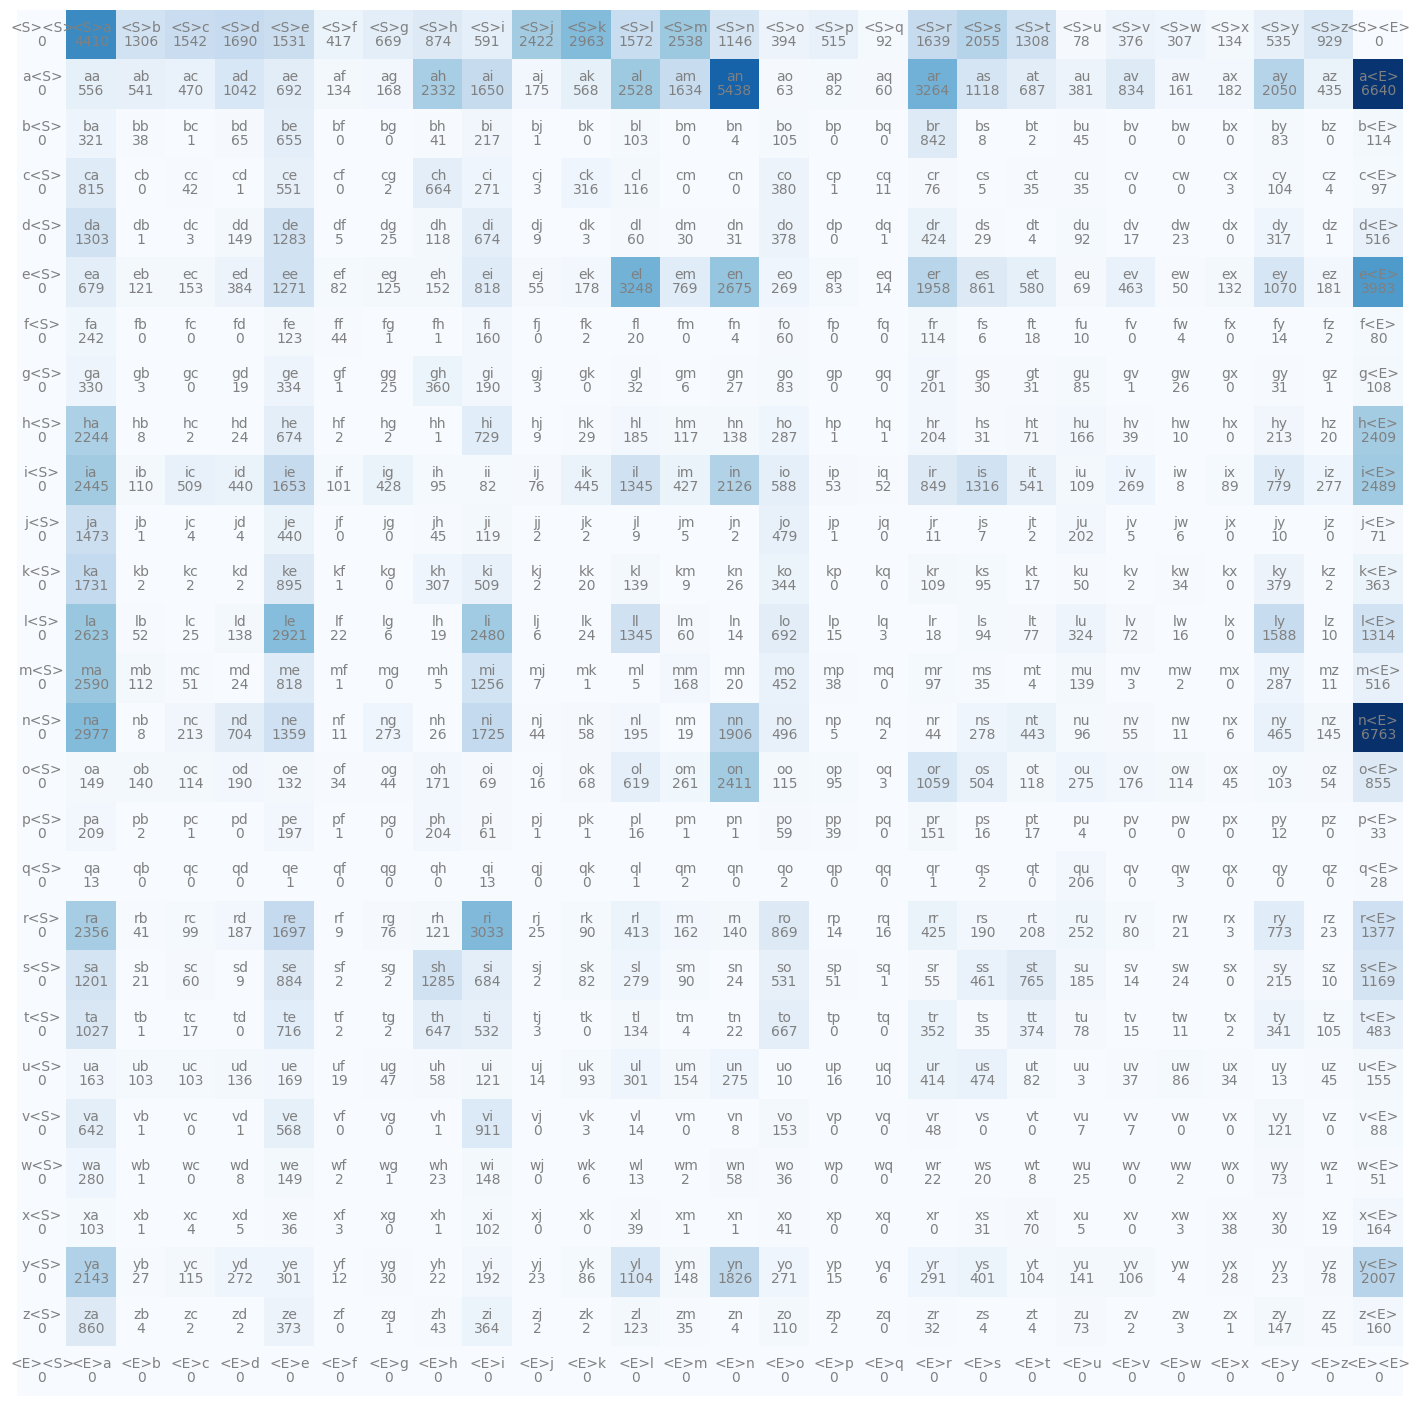

In [ ]:
# plot count matrix
plt.figure(figsize=(18, 18))
plt.imshow(N, cmap='Blues')
for i in range(len(N)):
  for j in range(len(N)):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')   
plt.axis('off')

Notice the following:

- last row of our array is all 0s. This is because the end-of-word character *\<E>* (by definition) can never be followed by anything else
- first column is all 0s because the start-of-word character *\<S>* can never follow any other character

There is no need to distinguish between the start-of-word and end-of-word delimiter tokens. As far as our algorithm is concerned, a single special delimiter token is adequate to mark both the start and end of words.

Let's do some cleanup!

In [ ]:
# define delimiter character (can be any character that is
# guaranteed to not appear in words)
delimiter_char = '.'

chars = sorted(list(set(''.join(words))))
chars.insert(0, delimiter_char)
print(f'char count: {len(chars)}')

# create tensor
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)

# create char-to-count and count-to-char mappings
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}

char count: 27


In [ ]:
# populate Bigram count matrix
for w in words:
  tagged_w = [delimiter_char] + list(w) + [delimiter_char]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    ix1, ix2 = stoi[c1], stoi[c2]
    N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

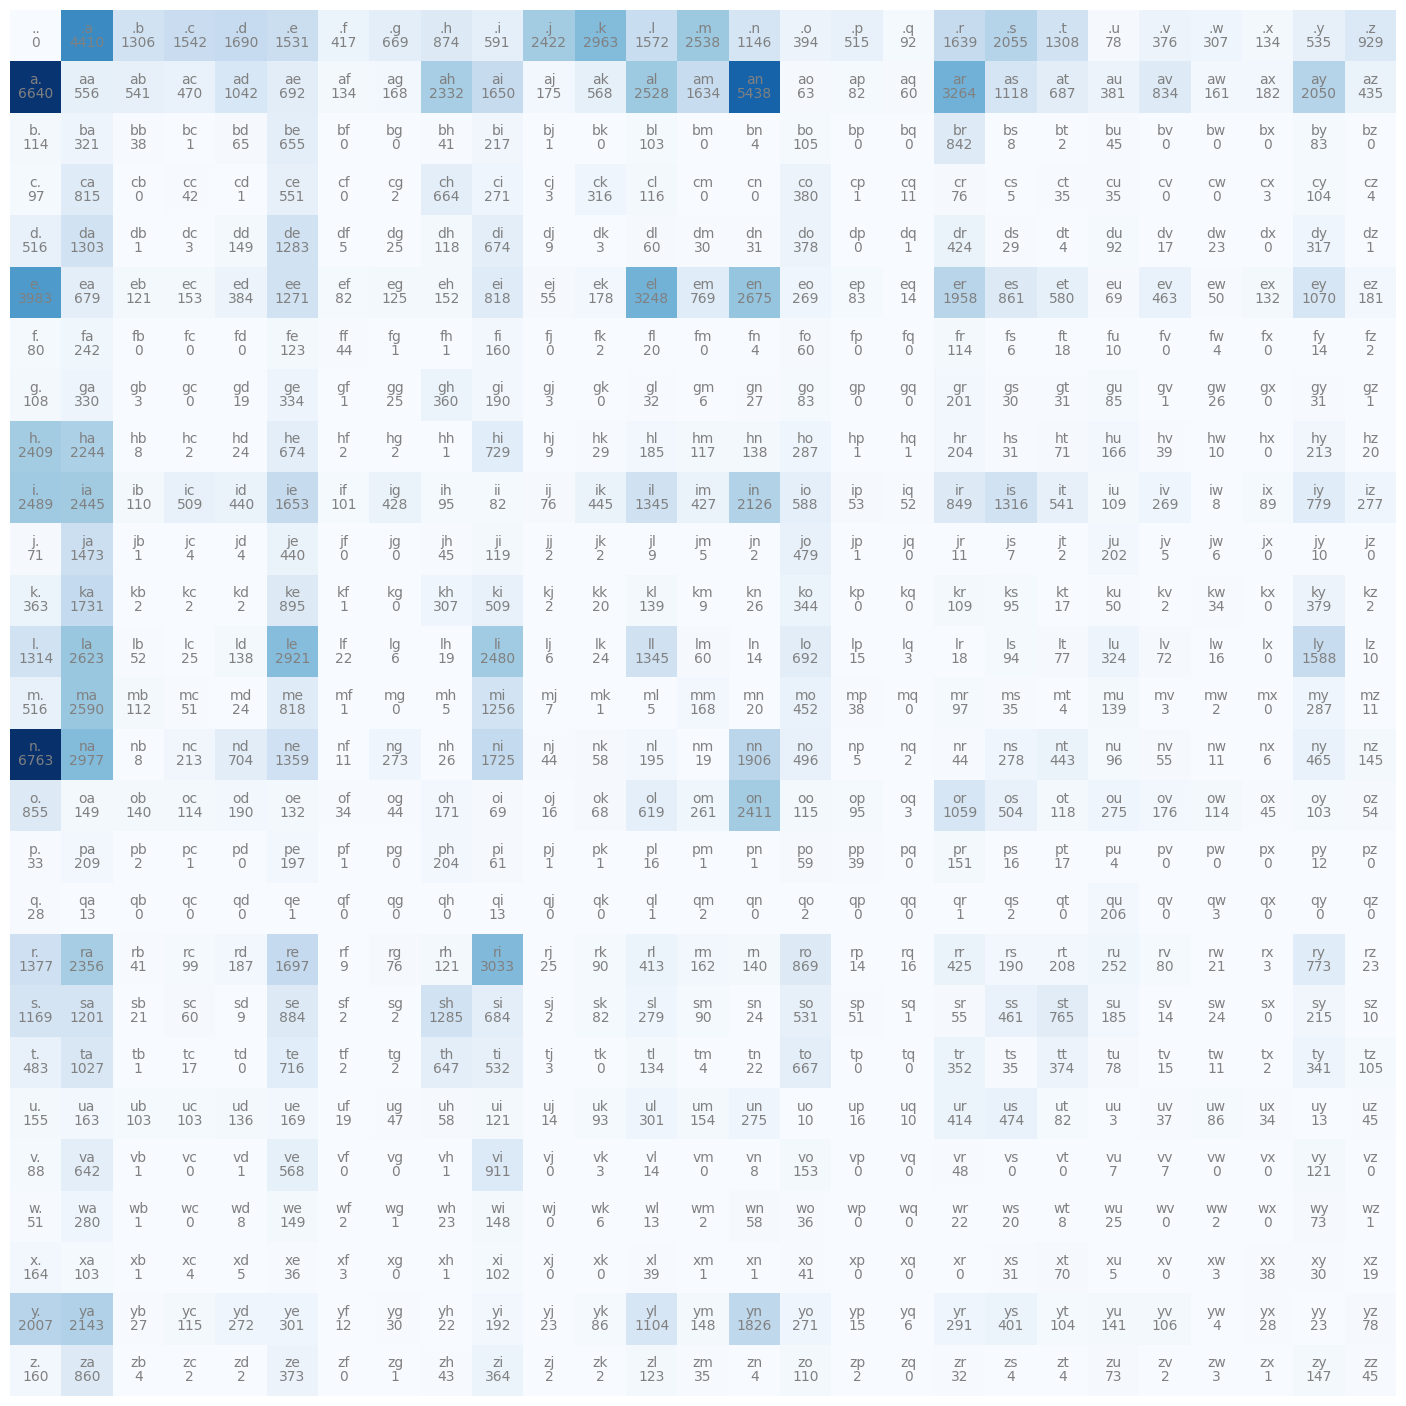

In [ ]:
# plot count matrix
plt.figure(figsize=(18, 18))
plt.imshow(N, cmap='Blues')
for i in range(len(N)):
  for j in range(len(N)):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')   
plt.axis('off')

Notice:

- N[0, 0] = 0 because there are no empty words (i.e. start-of-word followed by end-of-word)
- First row has counts of words that start with the given letter (i.e. start-of-word followed by given letter)
- First column has counts of words that end with the given letter (i.e. given letter followed by end-of-word)

This *counts array* has all the information we need to build our Bigram model!

In [ ]:
# For example, the first row tells us which characters are most likely to
# start a word.
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Now, we would like to convert these numbers into probabilities so we can sample from them.

In [ ]:
# first, convert integers to floats
p = N[0].float()
p

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])

In [ ]:
# now, compute probabilities
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [ ]:
# verify sum of probabilities is 1.0
p.sum()

tensor(1.)

To sample from this probability distribution we will use torch. Let's see how sampling works by creating a small demo:

- create a generator with manual seeding so that the results are repeatable
- generate 3 random numbers [0,1] using the generator
- compute probability distribution

In [ ]:
g = torch.Generator().manual_seed(6437375)

p = torch.rand(3, generator=g)
print(p)

p /= p.sum()
p

tensor([0.5073, 0.0683, 0.4917])


tensor([0.4753, 0.0640, 0.4607])

Given this distribution, using random sampling we would expect ≈ 47% the samples to be 0.5073 (index 0), ≈ 46% to be 0.4917 (index 2), and ≈ 0.06% to be 0.0683 (index 1).

We use torch to do this sampling. Below sampling output validates our expectation. 

In [ ]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Now we can use this sampling technique on our words matrix:

- sample index from the starting letter count row 
- use sampled index to extract the character
- print index and character

Doing this repeatedly should approximate the probability distribution of letter counts - i.e. letters (e.g. j, k, m, s, ...) that start the greatest number of words should be sampled more frequently. Left as an exercise to the reader!

In [ ]:
p = N[0].float()
p /= p.sum()

ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix_char = itos[ix]
print(f'{ix}: {ix_char}')

1: a


Now that we have the starting character, e.g. 'm', we do the following:

1. look at the leftmost column and find the row that has our starting character
2. use that row to compute the probability distribution
3. sample from the new probability to find the next character

Repeat steps 1-3 until:
  - end-of-word character is sampled

In [ ]:
g = torch.Generator().manual_seed(6437375)

ix = 0
new_name = []
while True:

  # compute probalilities
  p = N[ix].float()
  p /= p.sum()

  # sample
  ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

  # map index to character
  next_char = itos[ix]
  new_name.append(next_char)
  if next_char == delimiter_char:
    break

print(''.join(new_name))

ja.


In [ ]:
# we do one simple optimization - instead of repeatedly computing the
# probability for a row, we compute it once, cache, and reuse

# make a copy of count array
P = N.float()
print(P.shape)

# sum the column values and keep the dimension
S = P.sum(1, keepdim=True)
print(S.shape)

torch.Size([27, 27])
torch.Size([27, 1])


Notice that the shapes of the 2 tensors *align* and are therefore [broadcastable](https://pytorch.org/docs/stable/notes/broadcasting.html).

Warning: *keepdim=True* is essential for this to work. Make sure to get very comfortable with broadcasting rules and understand them well.

- 27, 27
- 27, 1

In [ ]:
P = P / S

In [ ]:
# rewrite name generation using cached probabilities
g = torch.Generator().manual_seed(6437375)

ix = 0
new_name = []
while True:

  # use pre-computed probabilities
  p = P[ix]
  
  ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
  next_char = itos[ix]
  new_name.append(next_char)
  if next_char == delimiter_char:
    break

print(''.join(new_name))

ja.


We can generate a batch of names.

In [ ]:
g = torch.Generator().manual_seed(6437375)

for i in range(20):
  ix = 0
  new_name = []
  while True:

    # use pre-computed probabilities
    p = P[ix]
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    next_char = itos[ix]
    new_name.append(next_char)
    if next_char == delimiter_char:
      break

  print(''.join(new_name))

ja.
eiein.
eladakun.
lami.
kahcovesann.
buiehiladatali.
jahalleymantanikth.
aini.
an.
battosh.
mexzandeshoms.
ryai.
amaicotoleaineenauaha.
q.
jeix.
ashanglvomaniilirarleleelava.
n.
riz.
jupramsyral.
ndacy.


What do you think? Frankly, the generated names are quite bad! For instance, single character names, e.g. *'n'*, and very long names, e.g. *ashanglvomaniilirarleleelava* are horrible choices for actual names, but the Bigram model does not know that! The fundamental issue is that the Bigram model is overly simplistic.

Let's think about how to evaluate the quality of this Bigram model, i.e. evaluate the model by looking at the training set and computing the loss.



Paused at 49:42

Let's look at our Bigrams and associated probabilities. For example, the probability of a *m* followed by another *m* is ≈2%.

If every letter was equally likely to follow every other letter then the probabilities would be identical for all Bigrams, i.e. $\frac{1}{27}≈0.037$ (26 letters of the English alphabet plus the delimiter character '.').

How can we summarize these probabilities into a single number that will tell us how good is out model? For that we can turn to the literature on [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#:~:text=In%20statistics%2C%20maximum%20likelihood%20estimation,observed%20data%20is%20most%20probable.) to understand the concept of *likelihood*. 

In our case, this is  the product of all the probabilities. Since this will a vanishingly small number, we will instead use the [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood). 

From log math we know that $log({a}\times{b}\times{c})=log(a)+log(b)+log(c)$.






In [ ]:
# compute log likelihood for first 3 words
log_likelihood = 0.0
for w in words[:3]:
  tagged_w = [delimiter_char] + list(w) + [delimiter_char]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    ix1, ix2 = stoi[c1], stoi[c2]
    
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    
    print(f'{c1}{c2}: {prob:.4f} {logprob: .4f}')

print(f'{log_likelihood=}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856)


What is the range of the *log likelihood*? If all the probabilities are 1.0 then the log likelihood will go to 0. As probabilities become smaller the log likelihood will become more negative.

These semantics are not aligned with the notion of a *loss function*. The semantics of a loss function are that *low is good* because the goal is to *minimize* the loss. So, we need to *invert* the *log likelihood*, called the *negative log likelihood*. 

The *negative log likelihood* is a very good loss function because the lowest it can get is 0, and the higher it is the worse are the model predictions.

Let's rewrite to compute *log likelihood*, *negative log likelihood*, and *average negative log likelihood*. 

GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
- equivalent to **maximizing** the **log likelihood** (because log is monotonic)
- equivalent to **minimizing** the **negative log likelihood**
- equivalent to **minimizing** the **average negative log likelihood**

In [ ]:
n = 0
log_likelihood = 0.0
for w in words[:3]:
  tagged_w = [delimiter_char] + list(w) + [delimiter_char]
  for c1, c2 in zip(tagged_w, tagged_w[1:]):
    ix1, ix2 = stoi[c1], stoi[c2]

    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

    print(f'{c1}{c2}: {prob:.4f} {logprob:.4f}')

negative_log_likelihood = -log_likelihood
print(f'{log_likelihood=}, {negative_log_likelihood=}, {negative_log_likelihood / n=}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856), negative_log_likelihood=tensor(38.7856), negative_log_likelihood / n=tensor(2.4241)
